<a href="https://colab.research.google.com/github/nbadino/ItaOil/blob/main/paralleltrends22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Ti diamo il benvenuto in Colab</h1>
</div>

Se conosci già Colab, guarda questo video per avere informazioni sulle tabelle interattive, sulla visualizzazione della cronologia del codice eseguito e sulla tavolozza dei comandi.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  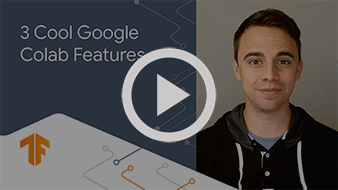
  </a>
</center>

<div class="markdown-google-sans">
  <h2>Cos'è Colab?</h2>
</div>

Colab, o "Colaboratory", ti permette di scrivere ed eseguire Python nel tuo browser con
- Nessuna configurazione necessaria
- Accesso alle GPU senza costi
- Condivisione semplificata

Che tu sia <strong>studente</strong>, <strong>data scientist</strong> o <strong>ricercatore AI</strong>, Colab può semplificarti il lavoro. Guarda <a href="https://www.youtube.com/watch?v=inN8seMm7UI">questo video introduttivo su Colab</a> per ulteriori informazioni oppure inizia qui sotto.

# Nuova sezione

In [8]:
!pip install tqdm
!pip install requests
import requests
import tarfile
import os
import concurrent.futures
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import shutil
shutil.rmtree("/content/datasets")



In [2]:

def download_and_extract(year, quarter, base_url, folder_name, pbar):
    # Construct the full URL
    file_url = f"{base_url}{year}/{year}_{quarter}_tr.tar.gz"

    # Ensure the directory exists
    folder_path = os.path.join("datasets", folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Download the file
    response = requests.get(file_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    file_path = os.path.join(folder_path, f"{year}_{quarter}_tr.tar.gz")

    with open(file_path, 'wb') as file:
        for data in tqdm(response.iter_content(block_size), desc=f"Downloading {year}_{quarter} to {folder_name}", total=total_size//block_size, unit='KiB', unit_scale=True):
            file.write(data)

    # Extract the tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        for member in tqdm(tar.getmembers(), desc=f"Extracting {year}_{quarter} to {folder_name}"):
            tar.extract(member, path=folder_path)

    # Remove the tar.gz file after extraction
    os.remove(file_path)
    pbar.update(1)

# Base URLs and corresponding folders
url_folder_mapping = {
    "https://opendatacarburanti.mise.gov.it/categorized/anagrafica_impianti_attivi/": "anagrafica",
    "https://opendatacarburanti.mise.gov.it/categorized/prezzo_alle_8/": "prezzi"
}

tasks = [(year, quarter, base_url, folder_name) for base_url, folder_name in url_folder_mapping.items() for year in range(2022, 2024) for quarter in range(1, 5) if not (year == 2023 and quarter > 2)]

# Use a ThreadPoolExecutor to download multiple files concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor, tqdm(total=len(tasks), desc="Overall Progress", position=0) as pbar:
    futures = [executor.submit(download_and_extract, year, quarter, base_url, folder_name, pbar) for year, quarter, base_url, folder_name in tasks]

    for future in concurrent.futures.as_completed(futures):
        future.result()

print("Download and extraction complete!")


Overall Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Extracting 2022_1 to anagrafica:   0%|          | 0/88 [00:00<?, ?it/s]

Extracting 2022_2 to anagrafica:   0%|          | 0/91 [00:00<?, ?it/s]

Extracting 2022_4 to anagrafica:   0%|          | 0/92 [00:00<?, ?it/s]

Extracting 2022_3 to anagrafica:   0%|          | 0/93 [00:00<?, ?it/s]

Extracting 2022_1 to prezzi:   0%|          | 0/88 [00:00<?, ?it/s]

Extracting 2022_2 to prezzi:   0%|          | 0/91 [00:00<?, ?it/s]

Extracting 2023_1 to anagrafica:   0%|          | 0/90 [00:00<?, ?it/s]

Extracting 2023_2 to anagrafica:   0%|          | 0/91 [00:00<?, ?it/s]

Extracting 2022_4 to prezzi:   0%|          | 0/95 [00:00<?, ?it/s]

Extracting 2022_3 to prezzi:   0%|          | 0/93 [00:00<?, ?it/s]

Extracting 2023_1 to prezzi:   0%|          | 0/90 [00:00<?, ?it/s]

Extracting 2023_2 to prezzi:   0%|          | 0/91 [00:00<?, ?it/s]

Download and extraction complete!


In [14]:
import requests
import zipfile
import os
import concurrent.futures
from tqdm.notebook import tqdm

def download_and_extract_french(year, url_suffix):
    url = f"https://donnees.roulez-eco.fr/opendata/annee/{url_suffix}"

    # Ensure the directory exists
    folder_path = "datasets/french"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Download the file
    response = requests.get(url, stream=True)
    with open(f"{year}_response.txt", 'wb') as debug_file:
      for chunk in response.iter_content(chunk_size=1024):
        debug_file.write(chunk)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    file_path = os.path.join(folder_path, f"{year}.zip")

    with open(file_path, 'wb') as file:
        for data in tqdm(response.iter_content(block_size), desc=f"Downloading French data for {year}", total=total_size//block_size, unit='KiB', unit_scale=True):
            file.write(data)

    # Extract the .zip file
        # Extract the .zip file
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            for member in tqdm(zip_ref.infolist(), desc=f"Extracting French data for {year}"):
                zip_ref.extract(member, path=folder_path)
    except zipfile.BadZipFile:
        print(f"Warning: {file_path} is not a valid ZIP file and will be skipped.")


    # Remove the .zip file after extraction
    os.remove(file_path)
    pbar_french.update(1)

# Years and their corresponding URL suffixes
data_mapping = {
    "2022": "2022",
    "2023": "annee"
}

# Use a ThreadPoolExecutor to download multiple files concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor, tqdm(total=len(data_mapping), desc="French Data Progress", position=0) as pbar_french:
    futures = [executor.submit(download_and_extract_french, year, url_suffix) for year, url_suffix in data_mapping.items()]

    for future in concurrent.futures.as_completed(futures):
        future.result()

print("Download and extraction of French data complete!")


French Data Progress:   0%|          | 0/2 [00:00<?, ?it/s]

StreamConsumedError: ignored